# Featurizing the HCM Variants

## Importing relevant modules

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import collections
from scipy import stats
import os 
import requests
import re

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica Neue']

In [14]:
%reload_ext autoreload
%autoreload 1
%aimport ensembl_vep
%aimport coils_score
%aimport structure_score

In [220]:
gois = ['MYH7', 'ACTC1', 'MYL2', 'MYL3', 'MYBPC3', 'TPM1', 'TNNI3', 'TNNT2']
aa3to1 = {"Ala":"A","Arg":"R","Asn":"N","Asp":"D","Cys":"C","Glu":"E","Gln":"Q","Gly":"G","His":"H","Ile":"I",
"Leu":"L","Lys":"K","Met":"M","Phe":"F","Pro":"P","Ser":"S","Thr":"T","Trp":"W","Tyr":"Y","Val":"V", "Ter": "*"}
aa1to3 = {aa3to1[k]: k for k in aa3to1}

def protein_change_from_hgvs(df, hgvs_col):
    '''
    * Helper function used to clean variant datasets and ready them for COILS score calculation
    * Returns the protein change implied by the HGVS notation in column hgvs_col in data frame df
    '''
    hgvs_list = list(df[hgvs_col])
    
    pattern = 'p\.(.{3})([0-9]+)(.{3})'
    pattern_search = [re.search(pattern, s) for s in hgvs_list]
    
    aa_ref = [s.group(1) for s in pattern_search]
    pos =[s.group(2) for s in pattern_search]
    aa_var = [s.group(3) for s in pattern_search]

    return [aa3to1[aa_ref[i]] + pos[i] + aa3to1[aa_var[i]] for i in range(len(pos))]

## Loading relevant data sets

In [493]:
# ClinVar data from previous project

# load data
hcm_vars = pd.read_csv('datasets/hcm_vars.csv', index_col=0)

# filter out missing data, data with unwanted characters, data that is not form genes of interest
hcm_vars = hcm_vars[~hcm_vars['Protein.Consequence'].isna()]
hcm_vars = hcm_vars[~hcm_vars['Protein.Consequence'].str.contains(r'=|\?')]
hcm_vars = hcm_vars[hcm_vars['GENE'].isin(gois)]

# filter in missense variants only 
hcm_vars = hcm_vars[hcm_vars['Annotation']=='missense_variant']

# create the protein_change column for the COILS score
hcm_vars['protein_change'] = protein_change_from_hgvs(hcm_vars, 'Protein.Consequence')

# create clinical_significance column
hcm_vars['clinical_significance'] = 'pathogenic'
hcm_vars.loc[~hcm_vars['Benign'].isna(), 'clinical_significance'] = 'benign'

# rename columns
hcm_vars.columns = ['VAR_ID', 'gene_name', 'AF_GNOMAD', 'AF_GNOMAD_AFR', 'AF_GNOMAD_AMR',
       'AF_GNOMAD_ASJ', 'AF_GNOMAD_EAS', 'AF_GNOMAD_FIN', 'AF_GNOMAD_NFE',
       'AF_GNOMAD_SAS', 'AF_GNOMAD_OTH', 'CHROM', 'POS', 'rs_id', 'REF', 'ALT',
       'Source', 'Consequence', 'Protein.Consequence',
       'Transcript.Consequence', 'Annotation', 'Flags', 'Allele.Count',
       'Allele.Number', 'Homozygote.Count', 'Hemizygote.Count',
       'Allele.Count.African', 'Allele.Number.African',
       'Homozygote.Count.African', 'Hemizygote.Count.African',
       'Allele.Count.Latino', 'Allele.Number.Latino',
       'Homozygote.Count.Latino', 'Hemizygote.Count.Latino',
       'Allele.Count.Ashkenazi.Jewish', 'Allele.Number.Ashkenazi.Jewish',
       'Homozygote.Count.Ashkenazi.Jewish',
       'Hemizygote.Count.Ashkenazi.Jewish', 'Allele.Count.East.Asian',
       'Allele.Number.East.Asian', 'Homozygote.Count.East.Asian',
       'Hemizygote.Count.East.Asian', 'Allele.Count.European..Finnish.',
       'Allele.Number.European..Finnish.',
       'Homozygote.Count.European..Finnish.',
       'Hemizygote.Count.European..Finnish.',
       'Allele.Count.European..non.Finnish.',
       'Allele.Number.European..non.Finnish.',
       'Homozygote.Count.European..non.Finnish.',
       'Hemizygote.Count.European..non.Finnish.', 'Allele.Count.Other',
       'Allele.Number.Other', 'Homozygote.Count.Other',
       'Hemizygote.Count.Other', 'Allele.Count.South.Asian',
       'Allele.Number.South.Asian', 'Homozygote.Count.South.Asian',
       'Hemizygote.Count.South.Asian', 'VUS_LP_P', 'LP_P', 'Benign',
       'protein_change', 'clinical_significance']

In [494]:
# Jordan et al. 2011 data: the 74 'gold-standard' variants

# load data
jordan_data = pd.read_csv('datasets/svm_variants.csv', index_col=0)

# created hgvs notation columns for ENSEMBL VEP annotation
jordan_data['hgvs'] = jordan_data["NCBI protein accession"] + ":" + jordan_data["Amino acid change"]
jordan_data['hgvs_2'] = jordan_data["NCBI mRNA accession"] + ":" + jordan_data["cDNA change"]

jordan_data['protein_change'] = protein_change_from_hgvs(jordan_data, 'hgvs')

jordan_data.columns = ['gene_name', 'NCBI mRNA accession', 'NCBI protein accession', 'cDNA change',
       'Amino acid change', 'clinical_significance', 'hgvs', 'hgvs_2', 'protein_change']


In [495]:
# Data from ClinVar search

# load data
variants = pd.read_csv('datasets/clinvar_result.txt', sep = '\t')
variants = variants.loc[:, ~variants.columns.str.contains('^Unnamed')]

# filter out missing names, filter in names with cdna change
variants = variants[~variants['Name'].isna()]
variants = variants[variants['Name'].str.contains(r'.c')]

# filter out unwanted characters and data without protein changes
variants = variants[~variants['Name'].str.contains(r'=')]
variants = variants[~variants['Protein change'].isna()]

# only keep variants with a protein change that can be known from either one of two columns
variants = variants[(variants['Name'].str.contains(r'.p')) | ~(variants['Protein change'].str.contains(r','))]

# rename columns
variants.columns = ['hgvs', 'gene_name', 'protein_change', 'Condition(s)',
       'clinical_significance', 'Review status', 'Accession',
       'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome',
       'GRCh38Location', 'VariationID', 'AlleleID(s)', 'rs_id',
       'Canonical SPDI']

In [496]:
# Data from gnomAD

# load data
gnomad_data = pd.read_csv('datasets/HCM_gnomad.csv', index_col = 0)

# filter in missense variants from genes of interest 
gnomad_data = gnomad_data[(gnomad_data['GENE'].isin(gois)) & (gnomad_data['Annotation']=='missense_variant')]

# filter out variants without an rsID
gnomad_data = gnomad_data[~gnomad_data['ID'].isna()]

# filter in variants with a frequency high enough to be considered benign
gnomad_data = gnomad_data[gnomad_data['AF_GNOMAD'] > 4e-5]

# add protein_change and clinical_significance columns
gnomad_data['protein_change'] = protein_change_from_hgvs(gnomad_data, 'Protein.Consequence')
gnomad_data['clinical_significance'] = 'benign' 

# make sure column names are as expected
gnomad_data.columns = ['gene_name', 'AF_GNOMAD', 'AF_GNOMAD_AFR', 'AF_GNOMAD_AMR', 'AF_GNOMAD_ASJ',
       'AF_GNOMAD_EAS', 'AF_GNOMAD_FIN', 'AF_GNOMAD_NFE', 'AF_GNOMAD_SAS',
       'AF_GNOMAD_OTH', 'VAR_ID', 'CHROM', 'POS', 'rs_id', 'REF', 'ALT', 'Source',
       'Consequence', 'Protein.Consequence', 'Transcript.Consequence',
       'Annotation', 'Flags', 'Allele.Count', 'Allele.Number',
       'Homozygote.Count', 'Hemizygote.Count', 'Allele.Count.African',
       'Allele.Number.African', 'Homozygote.Count.African',
       'Hemizygote.Count.African', 'Allele.Count.Latino',
       'Allele.Number.Latino', 'Homozygote.Count.Latino',
       'Hemizygote.Count.Latino', 'Allele.Count.Ashkenazi.Jewish',
       'Allele.Number.Ashkenazi.Jewish', 'Homozygote.Count.Ashkenazi.Jewish',
       'Hemizygote.Count.Ashkenazi.Jewish', 'Allele.Count.East.Asian',
       'Allele.Number.East.Asian', 'Homozygote.Count.East.Asian',
       'Hemizygote.Count.East.Asian', 'Allele.Count.European..Finnish.',
       'Allele.Number.European..Finnish.',
       'Homozygote.Count.European..Finnish.',
       'Hemizygote.Count.European..Finnish.',
       'Allele.Count.European..non.Finnish.',
       'Allele.Number.European..non.Finnish.',
       'Homozygote.Count.European..non.Finnish.',
       'Hemizygote.Count.European..non.Finnish.', 'Allele.Count.Other',
       'Allele.Number.Other', 'Homozygote.Count.Other',
       'Hemizygote.Count.Other', 'Allele.Count.South.Asian',
       'Allele.Number.South.Asian', 'Homozygote.Count.South.Asian',
       'Hemizygote.Count.South.Asian', 'protein_change',
       'clinical_significance']

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [500]:
# merge all variant tables
# choose depending on analysis (with or without gnomad_data):

# all_variants = pd.concat([variants, hcm_vars, jordan_data], axis = 0, ignore_index=True)
all_variants = pd.concat([variants, hcm_vars, gnomad_data, jordan_data], axis = 0, ignore_index=True)

# remove duplicates with same gene_name and protein_change (also removes rsID duplicates)
all_variants = all_variants.drop_duplicates(subset = ['gene_name', 'protein_change'], keep='first')
all_variants = all_variants.drop_duplicates(subset = ['rs_id'], keep='first')

all_variants = all_variants[all_variants['gene_name'].isin(gois)]

#### Additional clean-up

In [505]:
# in some of the datasets, the hgvs notation columns may have spaces, which 
# will not match the expectations of the following code

hgvs_list = (all_variants[~all_variants['hgvs'].isna()]['hgvs'])
hgvs_list_2 = (all_variants[~all_variants['hgvs_2'].isna()]['hgvs_2'])
hgvs_list = [x.replace(' ', '') for x in hgvs_list]
hgvs_list_2 = [x.replace(' ', '') for x in hgvs_list_2]
all_variants.loc[~all_variants['hgvs'].isna(), 'hgvs'] = hgvs_list
all_variants.loc[~all_variants['hgvs_2'].isna(), 'hgvs_2'] = hgvs_list_2

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Collecting the Ensembl VEP scores

In [508]:
import ensembl_vep
VEP = ensembl_vep.vep_features(df = all_variants, 
                                gene_name_col = "gene_name", 
                                hgvs_cols = ['hgvs', 'hgvs_2'], 
                                id_cols = ['rs_id'], 
                                conseqs = ["missense_variant", "start_lost"])

In [509]:
variants = VEP.featurize_variants()

Featurizing 136 variants!
sending request ... Done!
Featurizing 1 variants!
sending request ... Done!
Featurizing 331 variants!
sending request ... Done!
sending request ... Done!


In [538]:
variants = variants[variants['polyphen2_score'] != 'not_found']
variants = variants[variants['sift_score'] != 'not_found']

## Calculating the COILS scores

Strangely, a number of variants seem to have multiple protein changes despite the fact that only one posistion in the protein and cDNA are changed in the HGVS notation. Because our analysis must remain loyal to the HGVS analysis, we will resolve this problem by making sure that there is only one protein change per variant, and that this change matches the HGVS notation.

For example:

In [529]:
many_changes = variants[variants['protein_change'].str.contains(r',')]
many_changes.head()

,hgvs,gene_name,protein_change,Condition(s),clinical_significance,Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,cadd_raw,cadd_phred,polyphen2_score,polyphen2_pred,sift_score,sift_pred,COILS_maxdelta,COILS_normdelta,COILS_sumdelta,structure_score


In [512]:
variants.loc[variants['protein_change'].str.contains(r','), 'protein_change'] = protein_change_from_hgvs(many_changes, 'hgvs')

In [513]:
many_changes = variants[variants['protein_change'].str.contains(r',')]
many_changes.head()

,hgvs,gene_name,protein_change,Condition(s),clinical_significance,Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,cDNA change,Amino acid change,hgvs_2,blosum62,cadd_raw,cadd_phred,polyphen2_score,polyphen2_pred,sift_score,sift_pred


Fixed!

In [514]:
from coils_score import COILS

In [530]:
coils_scoring = COILS(df = variants,
                      gene_name_col = 'gene_name',
                      prot_change_col = 'protein_change', 
                      protein_dict = {'MYH7': 'P12883', 'TNNI3':'P19429', 'TNNT2':'P45379', 'TPM1':'P09493'}, 
                      analysis_name = '1', 
                      coilsdir = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/thesis_aim1.1/coils2/coils',
                      ncoils_abs_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/thesis_aim1.1/coils2/coils/ncoils-osf',
                      overwrite = True)

importing sequences


In [531]:
variants = coils_scoring.score()

|| MYH7 || generating input fasta file ... running ncoils ... 174 sequences   336690 aas   130760 in coil ... Scoring ... Done!
|| TNNI3 || generating input fasta file ... WARNING: I (ref) is not G (variant ref)
running ncoils ... 26 sequences     5460 aas      469 in coil ... Scoring ... Done!
|| TNNT2 || generating input fasta file ... WARNING: I (ref) is not R (variant ref)
running ncoils ... 34 sequences    10132 aas     4541 in coil ... Scoring ... Done!
|| TPM1 || generating input fasta file ... WARNING: S (ref) is not A (variant ref)
running ncoils ... 25 sequences     7100 aas     5754 in coil ... Scoring ... Done!


## Calculating the structure score

In [517]:
variants['structure_score'] = np.nan

In [34]:
from structure_score import StructScore

In [35]:
def read_fasta(file):
    lines = []
    with open(file, 'r') as file:
        for line in file:
            lines.append(line)
    return lines[1].strip()

def get_seq_from_api(accession):
    url = f"https://www.ebi.ac.uk/proteins/api/proteins?&accession={accession}"
    r = requests.get(url, headers={ "Accept" : "text/x-fasta"})
    sequence = ''.join(r.text.split('\n')[1:])
    return sequence

In [36]:
from Bio import pairwise2
from Bio.Align import substitution_matrices
blosum62 = substitution_matrices.load("BLOSUM62")

class alignment_map:
    def __init__(self, X, Y):
        print('aligning')
        alignment = pairwise2.align.localds(X, Y, blosum62, -3, -1)[0]
        self.alignment = alignment
        alX = alignment.seqA
        alY = alignment.seqB
        self.XtoY = {k:0 for k in range(1, len(X)+1)}
        self.YtoX = {k:0 for k in range(1, len(Y)+1)}
        idxX, idxY = 0, 0
        print('building map')
        for idx, c in enumerate(alX):
            if not c=='-':
                idxX += 1
            if not alY[idx]=='-':
                idxY += 1
            if not c=='-' and not alY[idx]=='-':
                self.XtoY[idxX] = idxY
                self.YtoX[idxY] = idxX

In [8]:
myh7_seq, pdb_myh7_seq = get_seq_from_api('P12883'), read_fasta('./pdb_sequences/1KK7_1.fasta')
myl2_seq, pdb_myl2_seq = get_seq_from_api('P10916'), read_fasta('./pdb_sequences/1KK7_2.fasta')
myl3_seq, pdb_myl3_seq = get_seq_from_api('P08590'), read_fasta('./pdb_sequences/1KK7_3.fasta')
tnnt2_seq, pdb_tnnt2_seq = get_seq_from_api('P45379'), read_fasta('./pdb_sequences/1YTZ_1.fasta')
tnni3_seq, pdb_tnni3_seq = get_seq_from_api('P19429'), read_fasta('./pdb_sequences/1YTZ_2.fasta')

In [9]:
myh7_map = alignment_map(myh7_seq, pdb_myh7_seq)
myl2_map = alignment_map(myl2_seq, pdb_myl2_seq)
myl3_map = alignment_map(myl3_seq, pdb_myl3_seq)
tnnt2_map = alignment_map(tnnt2_seq, pdb_tnnt2_seq)
tnni3_map = alignment_map(tnni3_seq, pdb_tnni3_seq)

aligning
building map
aligning
building map
aligning
building map
aligning
building map
aligning
building map


#### MYH7

In [38]:
S1 = [["1kk7"],["1kk8", "1b7t"]]
S2 = [["1kk7"],["1kqm", "1kwo", "1l2o"]]
S3 = [["1kk8", "1b7t"],["1kqm", "1kwo", "1l2o"]]
chain_dict = {'1kk7': 'A', '1kk8':'A', '1b7t':'A', "1kqm":'A', "1kwo":'A', "1l2o":'A'}


myh7_a = StructScore(name = 'myh7_a', 
                  sets = S1, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)
myh7_a.align()
myh7_a.pValues()

myh7_b = StructScore(name = 'myh7_b', 
                  sets = S2, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myh7_b.align()
myh7_b.pValues()

myh7_c = StructScore(name = 'myh7_c', 
                  sets = S3, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myh7_c.align()
myh7_c.pValues()

#### MYL2

In [39]:
S1 = [["1kk7"],["1kk8", "1b7t"]]
S2 = [["1kk7"],["1kqm", "1kwo", "1l2o"]]
S3 = [["1kk8", "1b7t"],["1kqm", "1kwo", "1l2o"]]

chain_dict = {'1kk7': 'Y', '1b7t':'Y', "1kqm":'B', "1kwo":'B', "1l2o":'B', '1kk8':'B'}

myl2_a = StructScore(name = 'myl2_a', 
                  sets = S1, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)
myl2_a.align()
myl2_a.pValues()

myl2_b = StructScore(name = 'myl2_b', 
                  sets = S2, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myl2_b.align()
myl2_b.pValues()

myl2_c= StructScore(name = 'myl2_c', 
                  sets = S3, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myl2_c.align()
myl2_c.pValues()

Aligning 1kk7 and 1kk8 with a window of 15
Aligning 1kk7 and 1b7t with a window of 15
Aligning 1kk7 and 1kqm with a window of 15
Aligning 1kk7 and 1kwo with a window of 15
Aligning 1kk7 and 1l2o with a window of 15
Aligning 1kk8 and 1kqm with a window of 15
Aligning 1kk8 and 1kwo with a window of 15
Aligning 1kk8 and 1l2o with a window of 15
Aligning 1b7t and 1kqm with a window of 15
Aligning 1b7t and 1kwo with a window of 15
Aligning 1b7t and 1l2o with a window of 15


#### MYL3

In [40]:
S1 = [["1kk7"],["1kk8", "1b7t"]]
S2 = [["1kk7"],["1kqm", "1kwo", "1l2o"]]
S3 = [["1kk8", "1b7t"],["1kqm", "1kwo", "1l2o"]]

chain_dict = {'1kk7': 'Z', '1kk8':'C', '1b7t':'Z', "1kqm":'C', "1kwo":'C', "1l2o":'C'}

myl3_a = StructScore(name = 'myl3_a', 
                  sets = S1, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)
myl3_a.align()
myl3_a.pValues()

myl3_b = StructScore(name = 'myl3_b', 
                  sets = S2, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myl3_b.align()
myl3_b.pValues()


myl3_c = StructScore(name = 'myl3_c', 
                  sets = S2, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)

myl3_c.align()
myl3_c.pValues()

Aligning 1kk7 and 1kk8 with a window of 15
Aligning 1kk7 and 1b7t with a window of 15
Aligning 1kk7 and 1kqm with a window of 15
Aligning 1kk7 and 1kwo with a window of 15
Aligning 1kk7 and 1l2o with a window of 15
Aligning 1kk7 and 1kqm with a window of 15
Aligning 1kk7 and 1kwo with a window of 15
Aligning 1kk7 and 1l2o with a window of 15


#### TNNI3

In [41]:
S1 = [["1ytz"],["1yv0"]]
chain_dict = {'1ytz': 'I', '1yv0':'I'}

tnni3 = StructScore(name = 'tnni3_a', 
                  sets = S1, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)
tnni3.align()
tnni3.pValues()

Aligning 1ytz and 1yv0 with a window of 15


#### TNNT2

In [42]:
S1 = [["1ytz"],["1yv0"]]
chain_dict = {'1ytz': 'T', '1yv0':'T'}

tnnt2 = StructScore(name = 'tnnt2_a', 
                  sets = S1, 
                  window = 15, 
                  chain_dict = chain_dict, 
                  folder = './pdb_files', 
                  lovoalign_path = '/Users/ralphestanboulieh/Desktop/01_Research_ManraiLab/proj_clingenomics/lovoalign/bin/lovoalign',
                  precomputed = False)
tnnt2.align()
tnnt2.pValues()

Aligning 1ytz and 1yv0 with a window of 15


In [532]:
myh7_p = pd.concat([myh7_a.p['0:1'], myh7_b.p['0:1'], myh7_c.p['0:1']], axis = 1).drop(0, axis = 0)
myh7_combined_p = myh7_a.Fisher(myh7_p)
myh7_pos = [int(x[1:-1]) for x in list(variants[variants['gene_name']=='MYH7']['protein_change'])]
myh7_structscore = []
for pos in myh7_pos:
    mapping = myh7_map.XtoY[pos]
    if mapping == 0:
        myh7_structscore.append(np.nan)
    else:
        myh7_structscore.append(myh7_combined_p[mapping])
        
myl2_p = pd.concat([myl2_a.p['0:1'], myl2_b.p['0:1'], myl2_c.p['0:1']], axis = 1).drop(0, axis = 0)
myl2_combined_p = myl2_a.Fisher(myl2_p)
myl2_pos = [int(x[1:-1]) for x in list(variants[variants['gene_name']=='MYL2']['protein_change'])]
myl2_structscore = []
for pos in myl2_pos:
    mapping = myl2_map.XtoY[pos]
    if mapping == 0:
        myl2_structscore.append(np.nan)
    else:
        myl2_structscore.append(myl2_combined_p.get(mapping, np.nan))
        

myl3_p = pd.concat([myl3_a.p['0:1'], myl3_b.p['0:1'], myl3_c.p['0:1']], axis = 1).drop(0, axis = 0)
myl3_combined_p = myl3_a.Fisher(myl3_p)
myl3_pos = [int(x[1:-1]) for x in list(variants[variants['gene_name']=='MYL3']['protein_change'])]
myl3_structscore = []
for pos in myl3_pos:
    mapping = myl3_map.XtoY[pos]
    if mapping == 0:
        myl3_structscore.append(np.nan)
    else:
        myl3_structscore.append(myl3_combined_p[mapping])
        
        
tnni3_pos = [int(x[1:-1]) for x in list(variants[variants['gene_name']=='TNNI3']['protein_change'])]
tnni3_structscore = []
for pos in tnni3_pos:
    mapping = tnni3_map.XtoY[pos]
    if mapping == 0:
        tnni3_structscore.append(np.nan)
    else:
        tnni3_structscore.append(tnni3.p['0:1'].get(mapping, np.nan))
        
tnnt2_pos = [int(x[1:-1]) for x in list(variants[variants['gene_name']=='TNNT2']['protein_change'])]
tnnt2_structscore = []
for pos in tnnt2_pos:
    mapping = tnnt2_map.XtoY[pos]
    if mapping == 0:
        tnnt2_structscore.append(np.nan)
    else:
        tnnt2_structscore.append(tnnt2.p['0:1'].get(mapping, np.nan))

In [550]:
variants.loc[variants['gene_name']=='MYH7', 'structure_score'] = myh7_structscore
variants.loc[variants['gene_name']=='MYL2', 'structure_score'] = myl2_structscore
variants.loc[variants['gene_name']=='MYL3', 'structure_score'] = myl3_structscore
variants.loc[variants['gene_name']=='TNNT2', 'structure_score'] = tnnt2_structscore
variants.loc[variants['gene_name']=='TNNI3', 'structure_score'] = tnni3_structscore

ValueError: cannot set using a multi-index selection indexer with a different length than the value

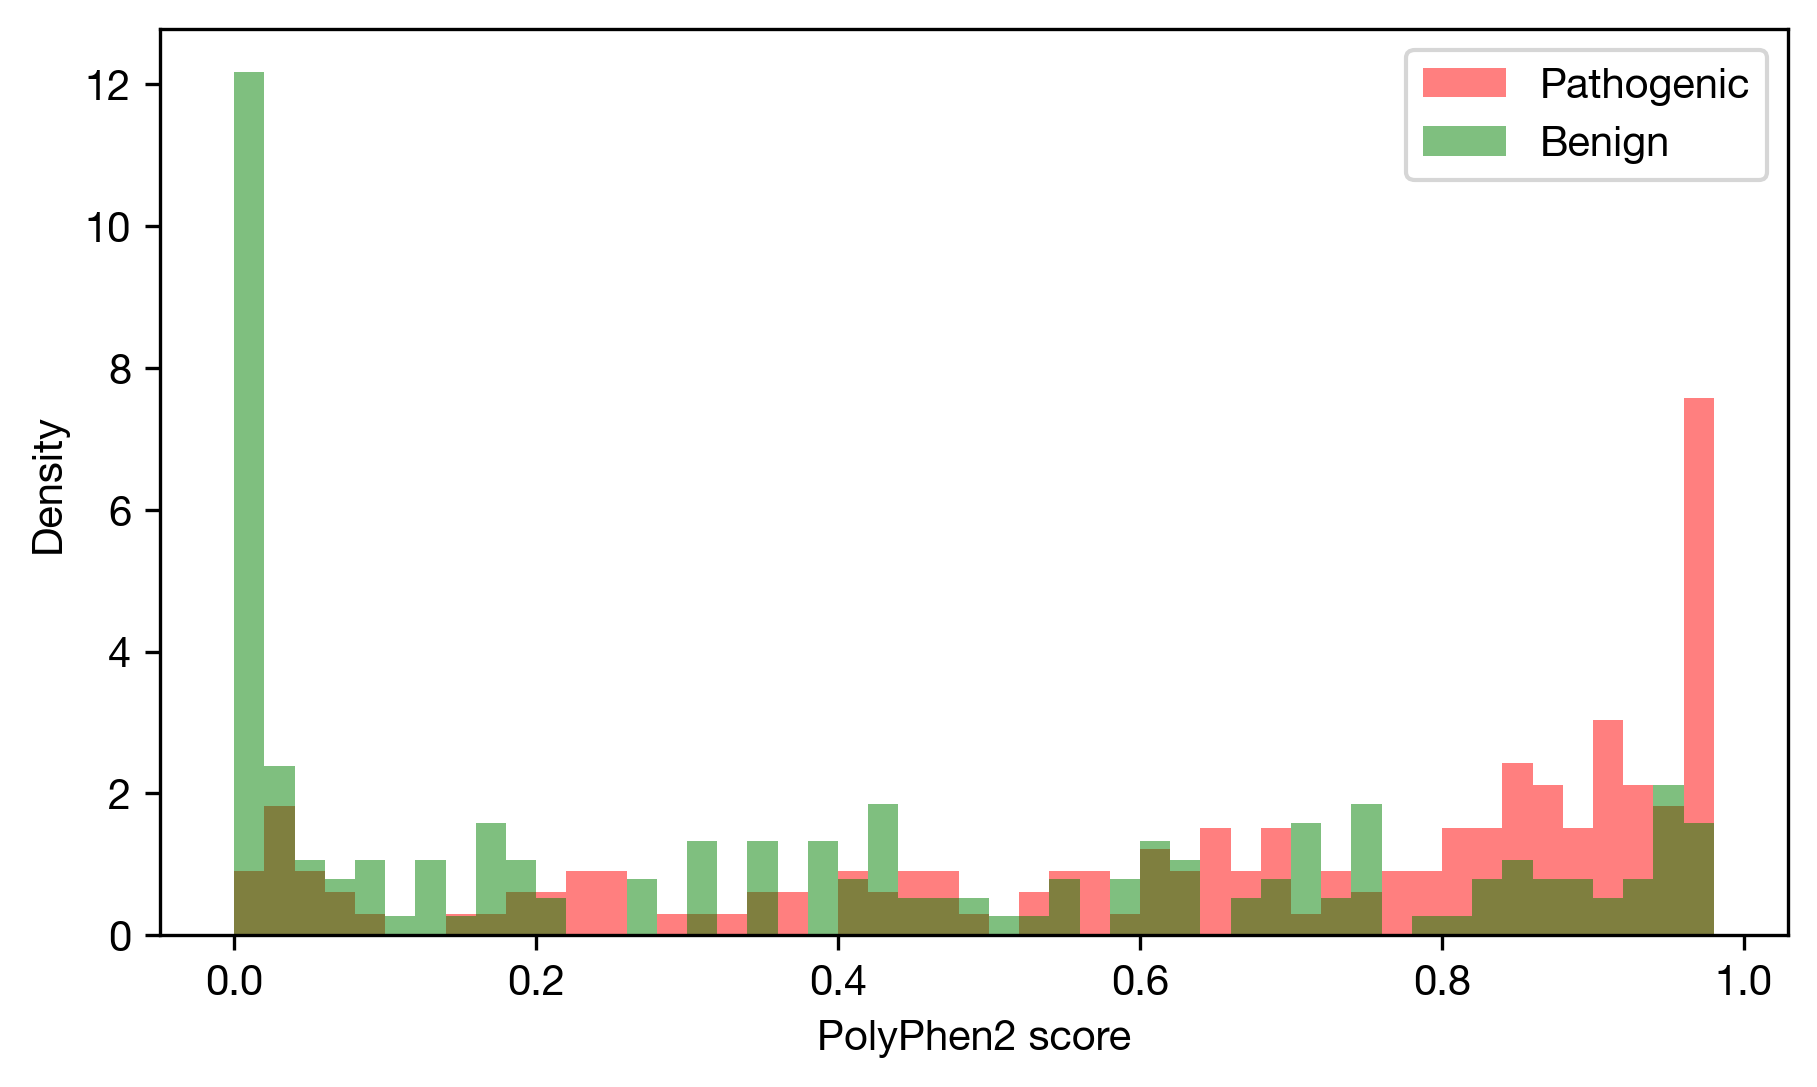

In [534]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[variants['clinical_significance'].str.contains(r'[p, P]athogenic')]['polyphen2_score'], 
         bins = np.arange(0, 1, 0.02), 
         color = 'r', 
         alpha = 0.5, 
         density=True);
ax.hist(variants[variants['clinical_significance'].str.contains(r'[b, B]enign')]['polyphen2_score'], 
         bins = np.arange(0, 1, 0.02), 
         color = 'g', 
         alpha = 0.5, 
         density=True);

ax.set_xlabel('PolyPhen2 score')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

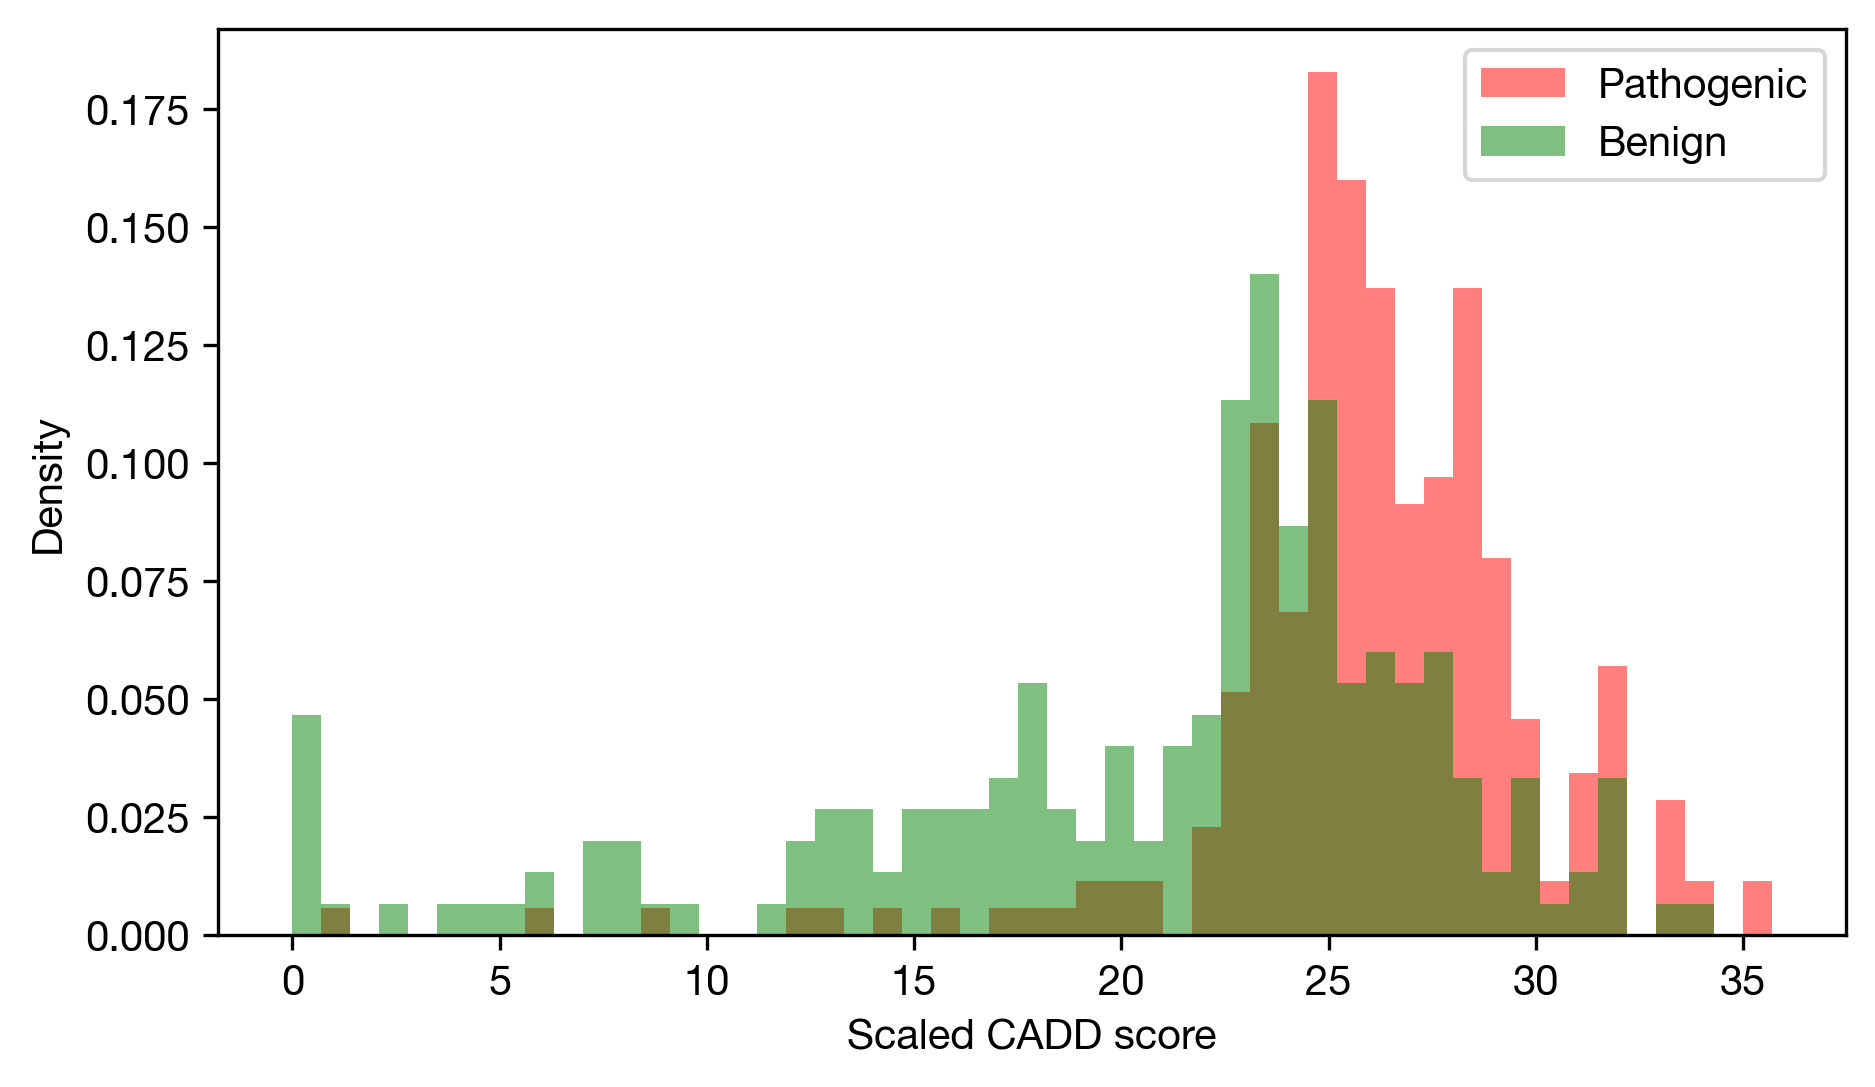

In [535]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[variants['clinical_significance'].str.contains(r'[p, P]athogenic')]['cadd_phred'], 
         bins = np.arange(0, 36, 0.7), 
         color = 'r', 
         alpha = 0.5, 
         density=True);
ax.hist(variants[variants['clinical_significance'].str.contains(r'[b, B]enign')]['cadd_phred'], 
         bins = np.arange(0, 36, 0.7), 
         color = 'g', 
         alpha = 0.5, 
         density=True);

ax.set_xlabel('Scaled CADD score')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

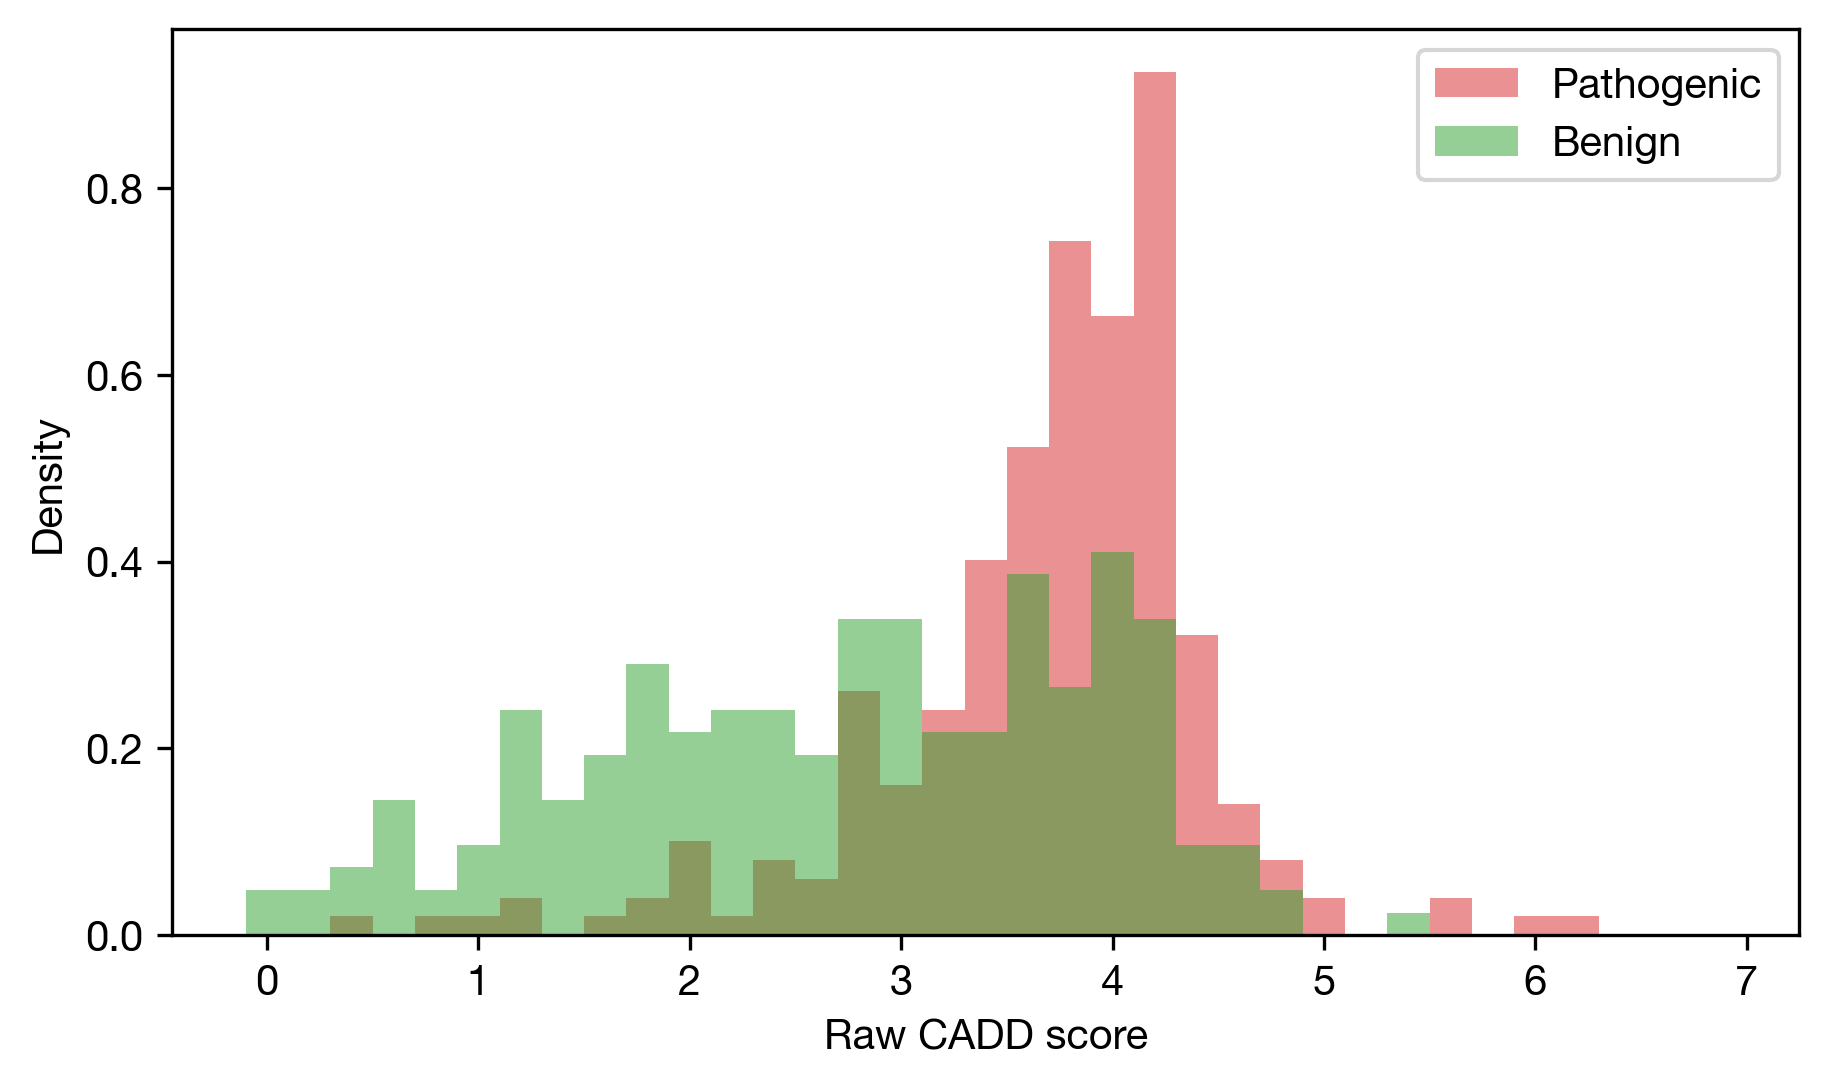

In [536]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[variants['clinical_significance'].str.contains(r'[p, P]athogenic')]['cadd_raw'], 
         bins = np.arange(-0.1, 7, 0.2), 
         color = 'tab:red', 
         alpha = 0.5, 
         density=True);
ax.hist(variants[variants['clinical_significance'].str.contains(r'[b, B]enign')]['cadd_raw'], 
         bins = np.arange(-0.1, 7, 0.2), 
         color = 'tab:green', 
         alpha = 0.5, 
         density=True);

ax.set_xlabel('Raw CADD score')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

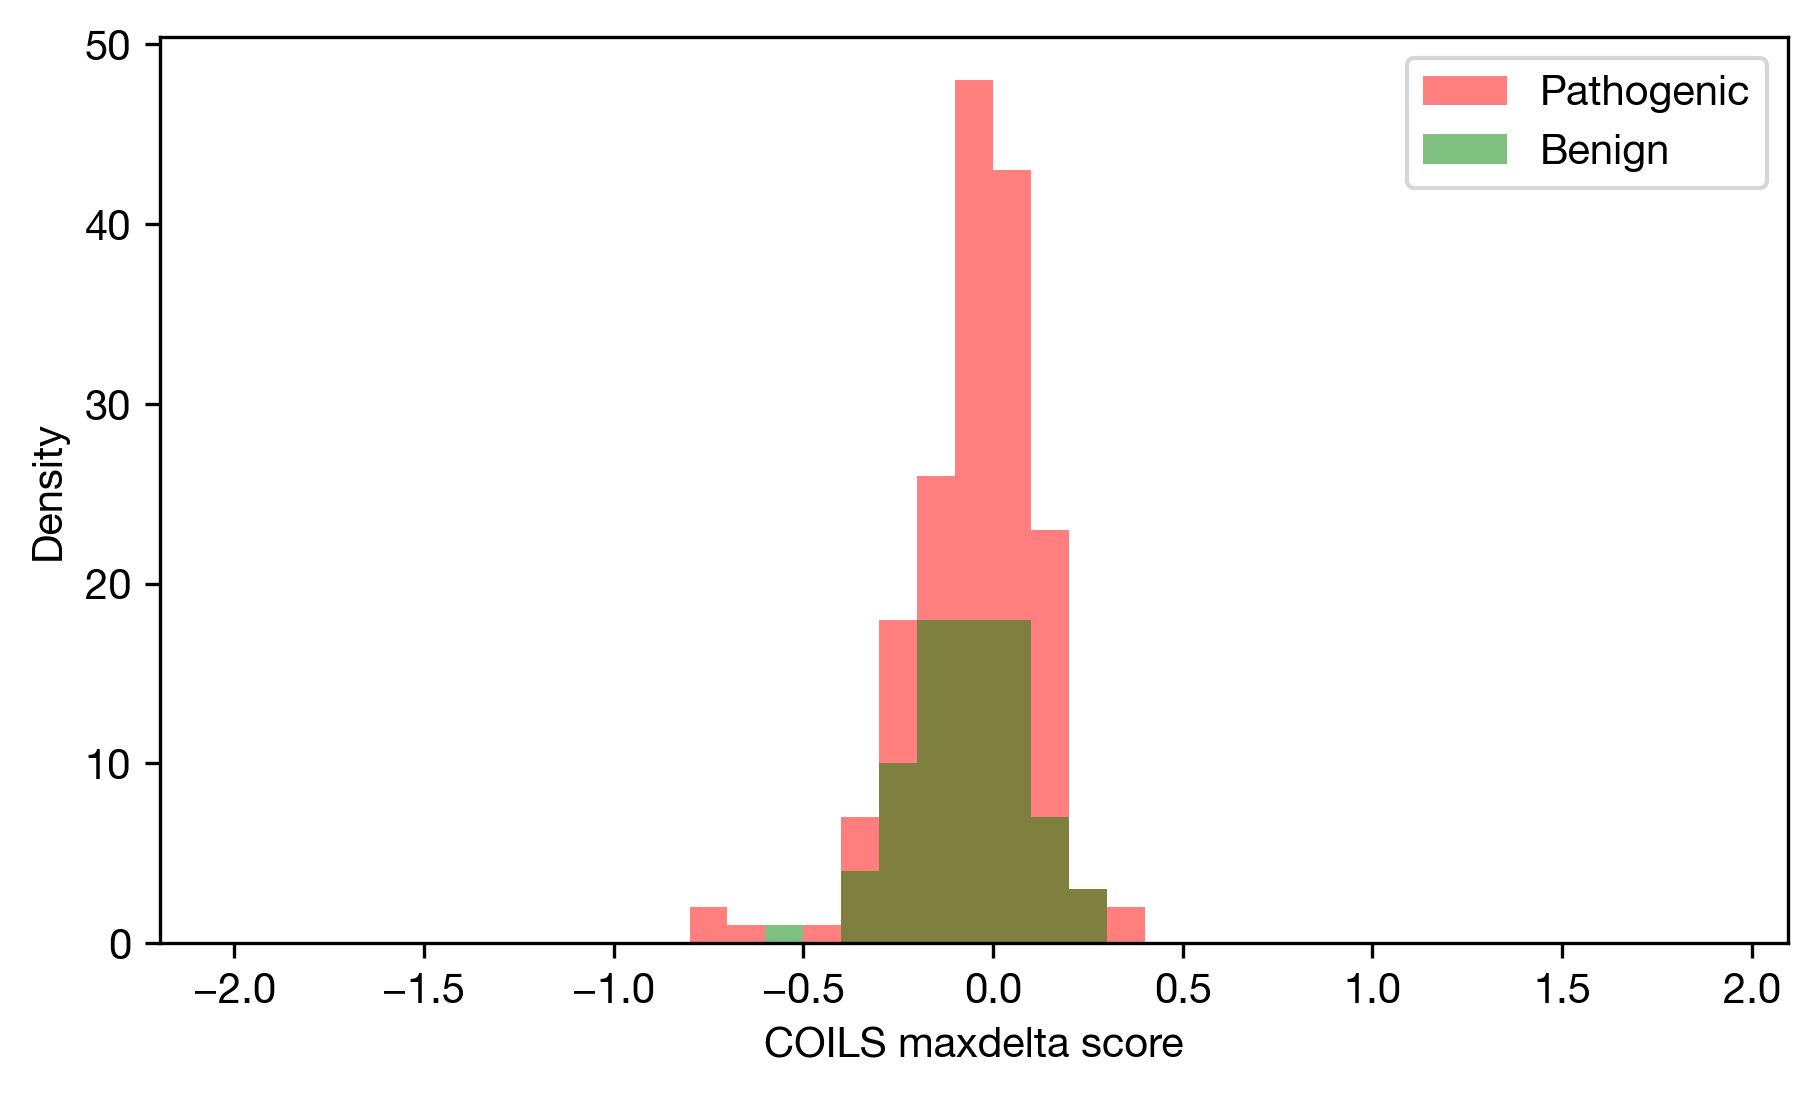

In [543]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[(variants['clinical_significance'].str.contains(r'[p, P]athogenic'))]['COILS_maxdelta'], 
         bins = np.arange(-2, 2, 0.1), 
         color = 'r', 
         alpha = 0.5, 
         density=False);
ax.hist(variants[(variants['clinical_significance'].str.contains(r'[b, B]enign'))]['COILS_maxdelta'], 
         bins = np.arange(-2, 2, 0.1), 
         color = 'g', 
         alpha = 0.5, 
         density=False);

ax.set_xlabel('COILS maxdelta score')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

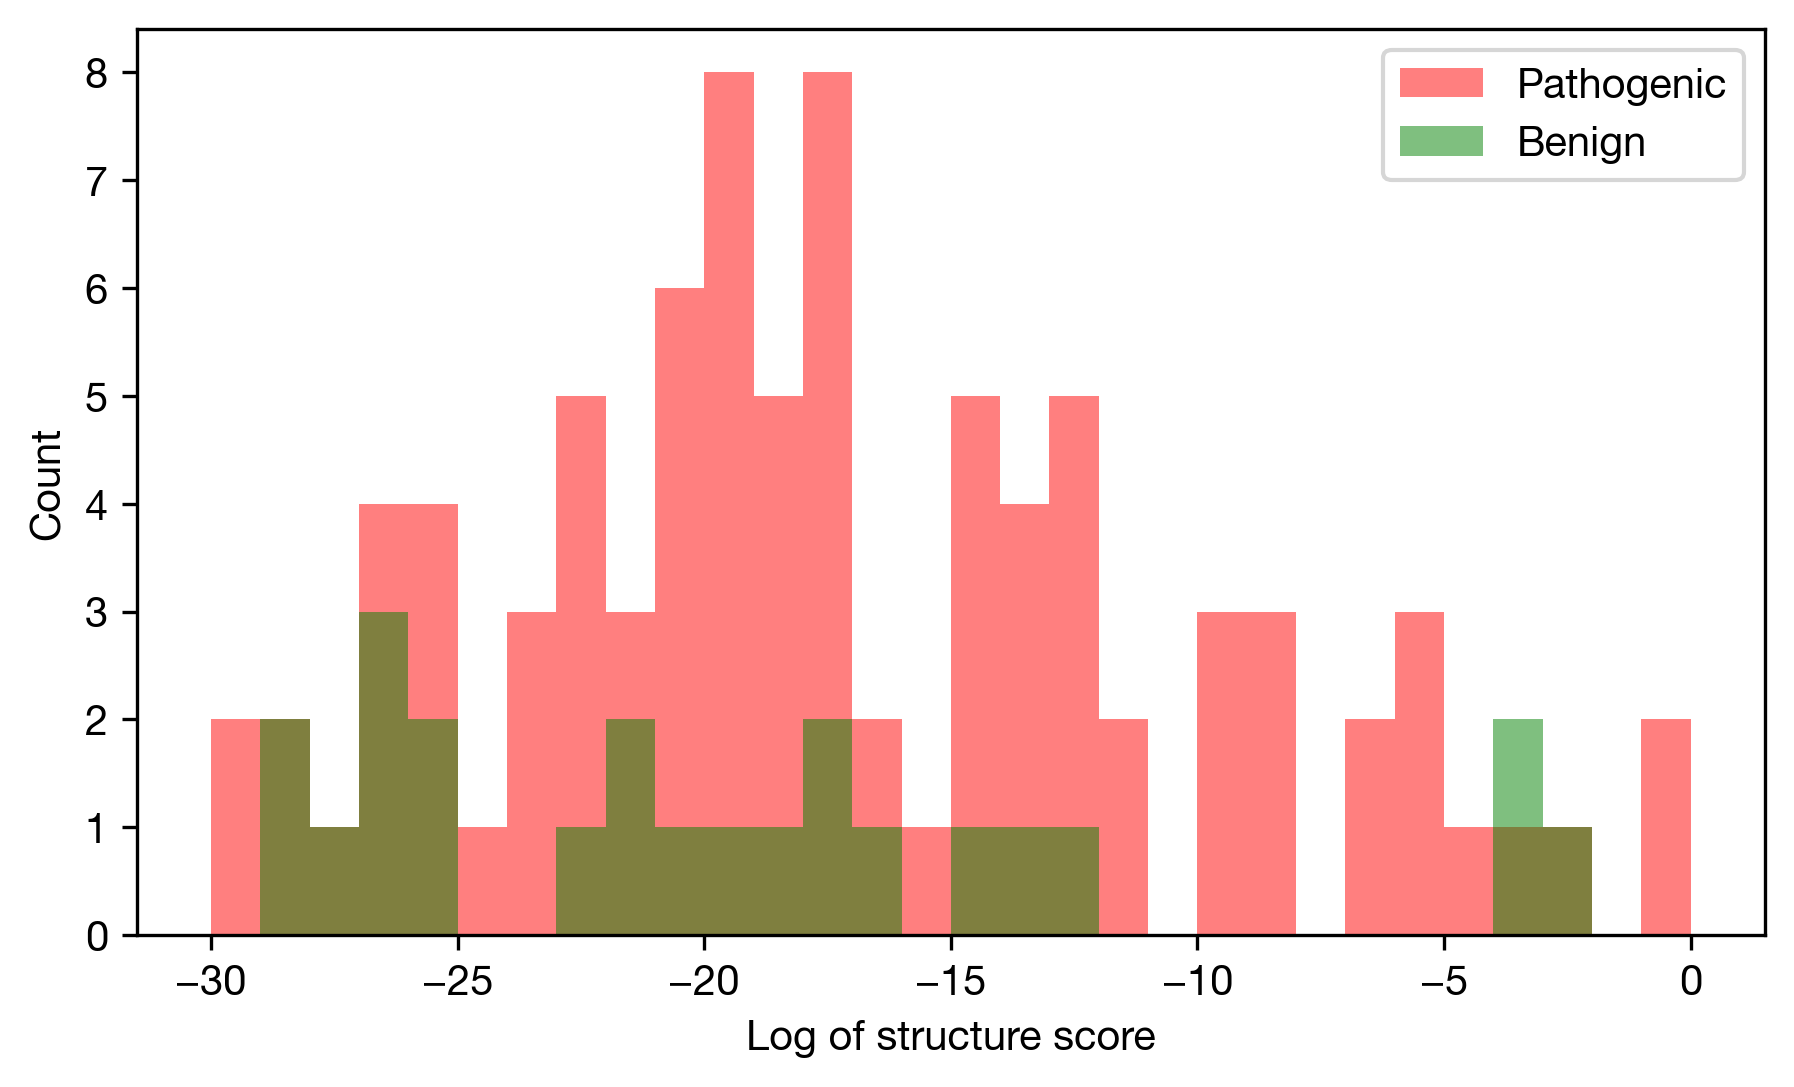

In [546]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(np.log(variants[(variants['clinical_significance'].str.contains(r'[p, P]athogenic'))]['structure_score']), 
         bins = np.arange(-30, 1, 1), 
         color = 'r', 
         alpha = 0.5, 
         density=False);
ax.hist(np.log(variants[(variants['clinical_significance'].str.contains(r'[b, B]enign'))]['structure_score']), 
         bins = np.arange(-30, 1, 1), 
         color = 'g', 
         alpha = 0.5, 
         density=False);

ax.set_xlabel('Log of structure score')
ax.set_ylabel('Count')
ax.legend(['Pathogenic', 'Benign']);

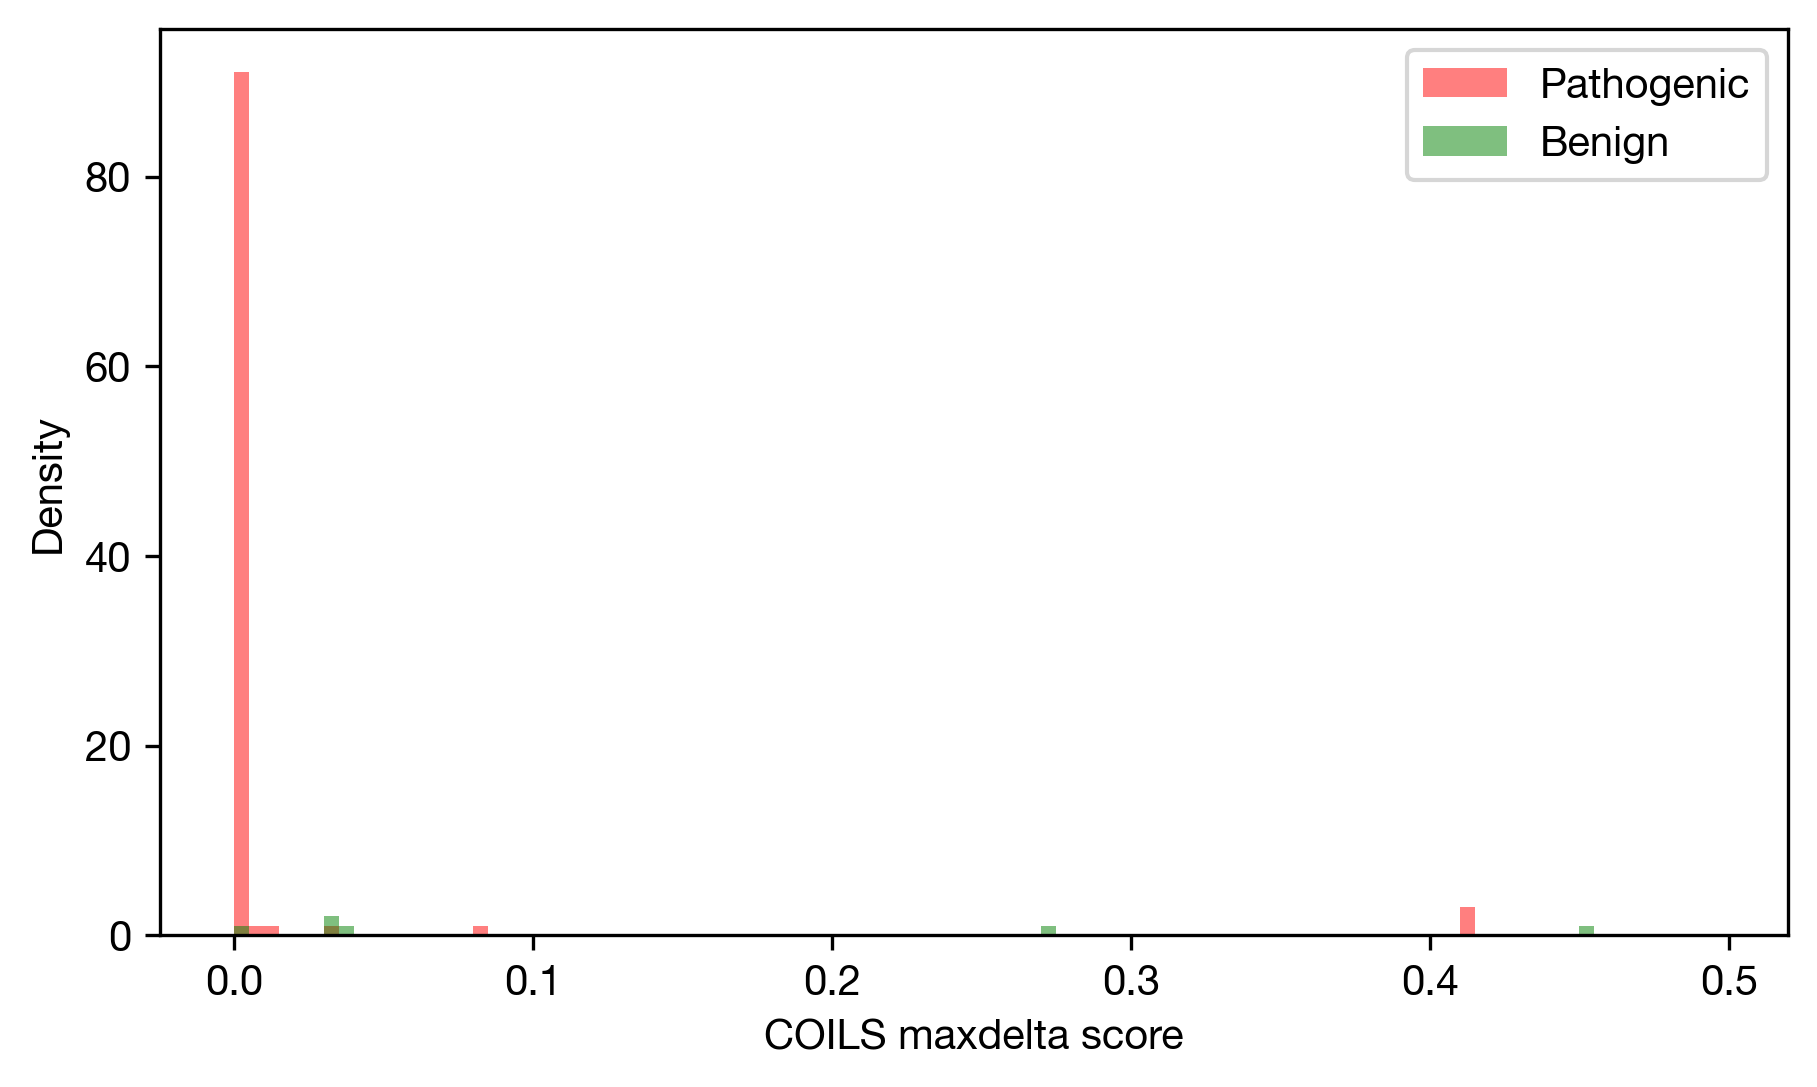

In [395]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[(variants['clinical_significance'].str.contains(r'[p, P]athogenic'))]['structure_score'], 
         bins = np.arange(0, 0.5, 0.005), 
         color = 'r', 
         alpha = 0.5, 
         density=False);
ax.hist(variants[(variants['clinical_significance'].str.contains(r'[b, B]enign'))]['structure_score'], 
         bins = np.arange(0, 0.5, 0.005), 
         color = 'g', 
         alpha = 0.5, 
         density=False);

ax.set_xlabel('COILS maxdelta score')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

## MrBayes

In [553]:
variants[variants['gene_name']=='ACTC1']

,hgvs,gene_name,protein_change,Condition(s),clinical_significance,Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,cadd_raw,cadd_phred,polyphen2_score,polyphen2_pred,sift_score,sift_pred,COILS_maxdelta,COILS_normdelta,COILS_sumdelta,structure_score
201,NaN,ACTC1,H90Y,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,...,4.18592,28.5,0.833,possibly_damaging,0.01,deleterious_low_confidence,NaN,NaN,NaN,NaN
265,NaN,ACTC1,I371T,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,...,4.26358,29.3,0.878,possibly_damaging,0,deleterious_low_confidence,NaN,NaN,NaN,NaN
310,NaN,ACTC1,N94S,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,...,3.98215,26.9,0.551,possibly_damaging,0.04,deleterious_low_confidence,NaN,NaN,NaN,NaN
340,NaN,ACTC1,L10M,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,...,3.72999,25.5,0.865,possibly_damaging,0.01,deleterious_low_confidence,NaN,NaN,NaN,NaN
358,NaN,ACTC1,C2Y,NaN,benign,NaN,NaN,NaN,NaN,NaN,...,3.58628,25,0.384,benign,0.05,deleterious_low_confidence,NaN,NaN,NaN,NaN


In [554]:
filenames = ['ACTC1', 'TNNT2', 'TNNI3', 'MYH7', 'MYL2', 'MYL3', 'TPM1', 'MYBPC3']
mb_params = {}
mb_runp = {}

for name in filenames:
    mb_params[name] = pd.read_csv(f'mrbayes/results/{name}_tree.pstat', sep='\t', skiprows = 1)
    mb_runp[name] = pd.read_csv(f'mrbayes/results/{name}_tree.run1.p', sep='\t', skiprows = 1)

In [555]:
genes = list(variants['gene_name'])
positions = [int(x[1:-1]) for x in list(variants['protein_change'])]
variants['mrbayes_rate'] = 1

for idx, gene, pos in zip(range(len(genes)), genes, positions):
    value = mb_params[gene][mb_params[gene]['Parameter']==f'r({pos})']['Mean'].item()
    variants.iloc[idx, -1] = value
    

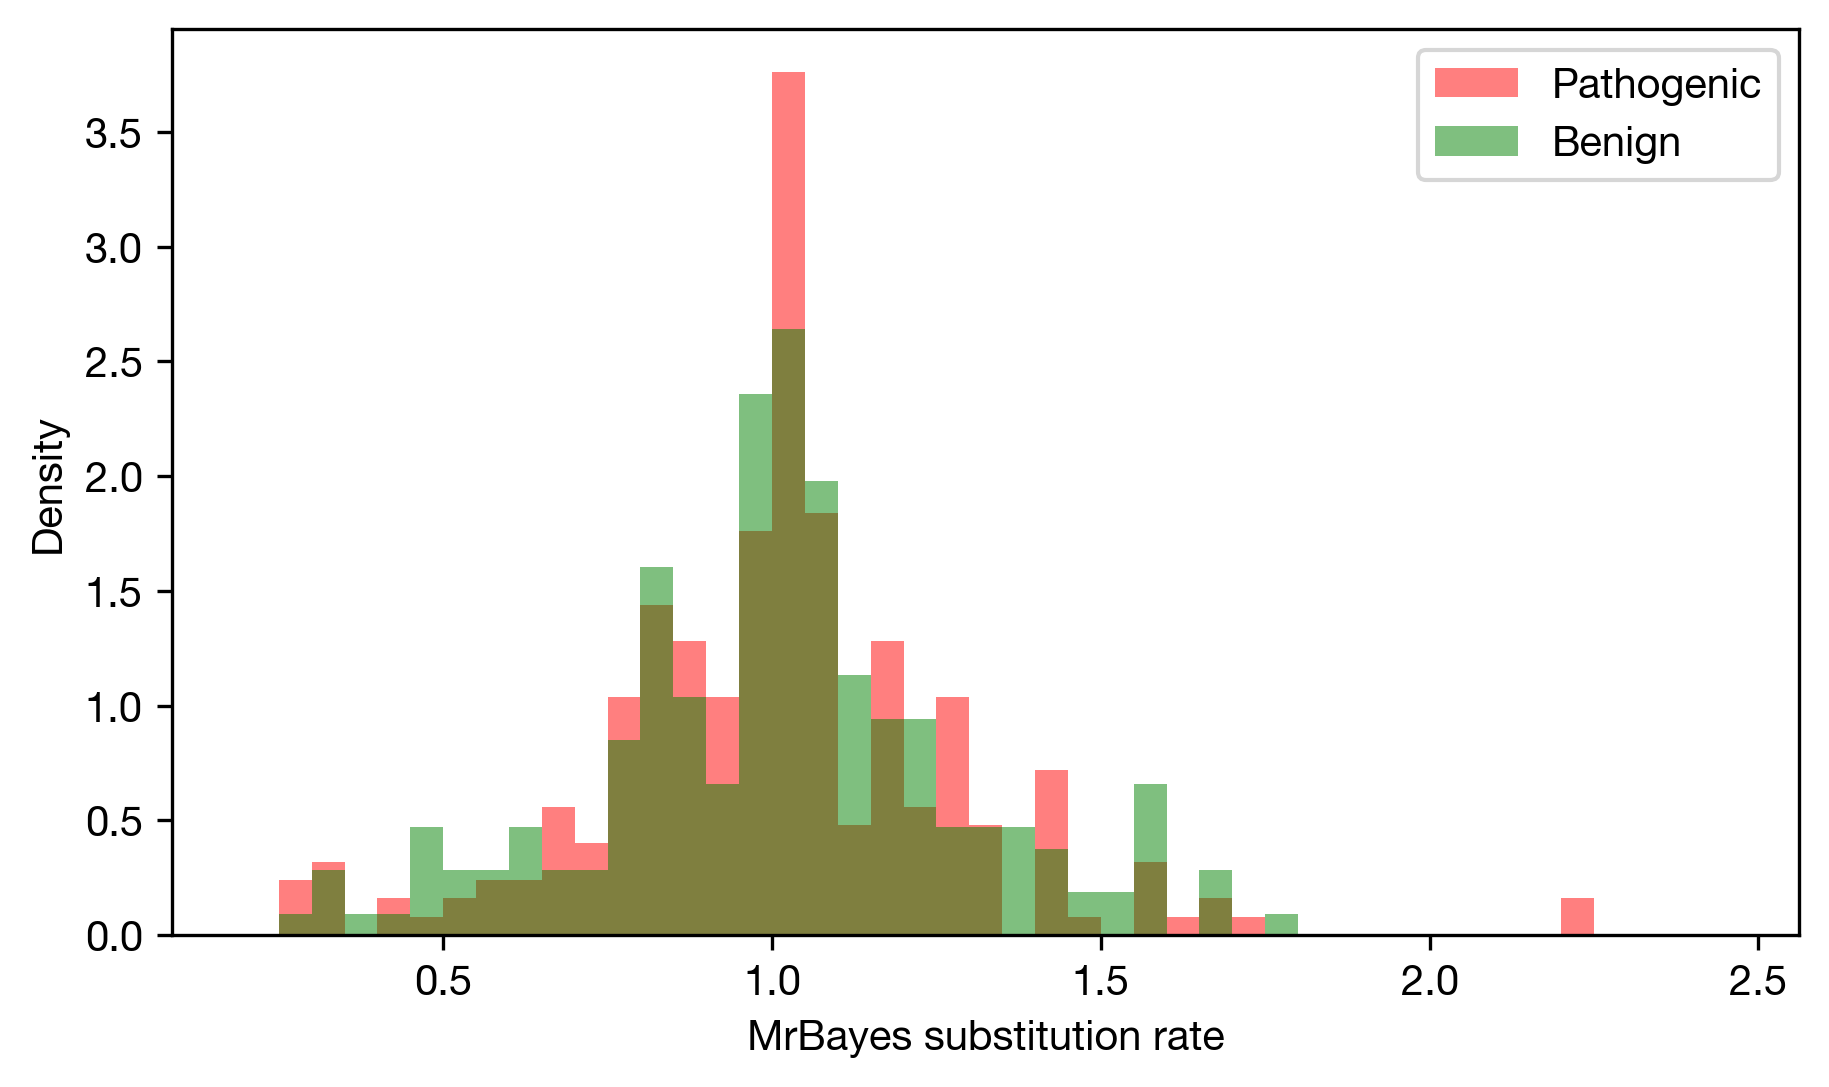

In [556]:
fig, ax = plt.subplots(figsize = (7, 4))

ax.hist(variants[(variants['clinical_significance'].str.contains(r'[p, P]athogenic'))]['mrbayes_rate'], 
         bins = np.arange(0.2, 2.5, 0.05), 
         color = 'r', 
         alpha = 0.5, 
         density=True);
ax.hist(variants[(variants['clinical_significance'].str.contains(r'[b, B]enign'))]['mrbayes_rate'], 
         bins = np.arange(0.2, 2.5, 0.05), 
         color = 'g', 
         alpha = 0.5, 
         density=True);

ax.set_xlabel('MrBayes substitution rate')
ax.set_ylabel('Density')
ax.legend(['Pathogenic', 'Benign']);

### Save as .CSV file

In [557]:
variants.to_csv('featurized_variants_gnomad.csv')

### Extra Strcuture Score Analysis

In [348]:
import statsmodels

In [86]:
all_rmsf = []
struct_objs = [myh7_a, myh7_b, myh7_c, myl2_a, myl2_b, myl2_c, myl3_a, myl3_b, myl3_c, tnni3, tnnt2]

for struct_obj in struct_objs:
        for al in struct_obj.alignments:
            stds = np.sqrt(struct_obj.alVariance[al])
            norm_rmsf = struct_obj.alAvgRMSF[al]/stds
            all_rmsf += list(norm_rmsf)


In [350]:
ecdf = statsmodels.distributions.empirical_distribution.ECDF(all_rmsf)

In [357]:
a,z

(array([2.10150098, 0.37718667, 0.1601692 ]),
 array([0.0601192 , 0.43966485, 0.50021595]))

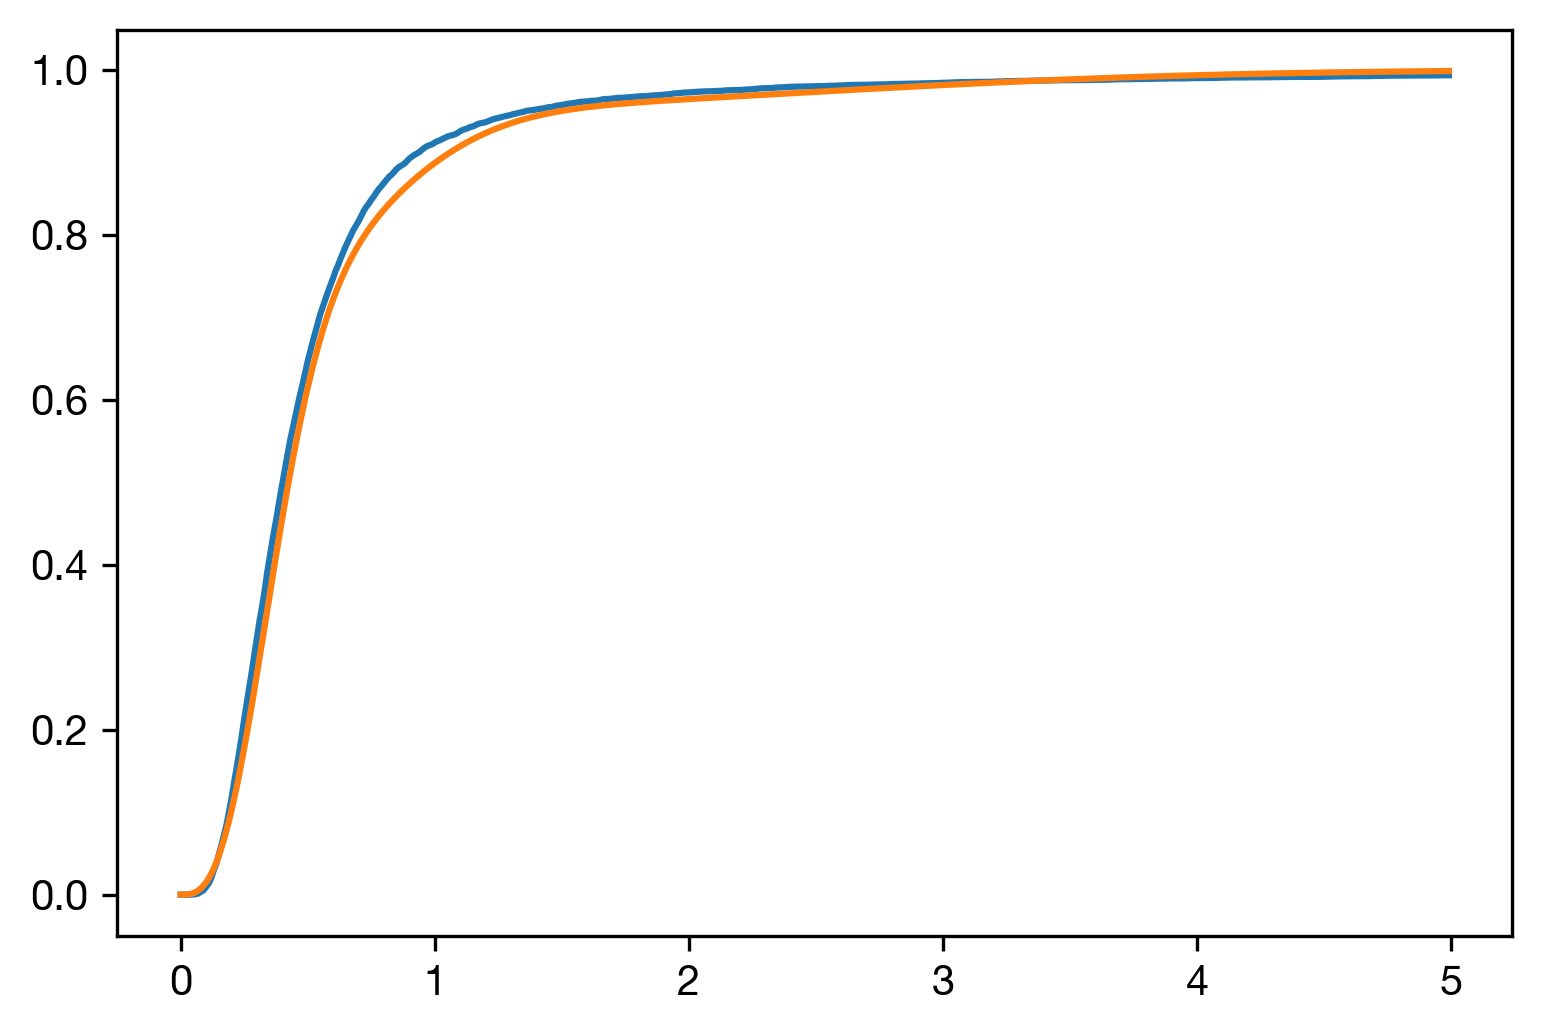

In [390]:
plt.plot(x, ecdf(x))
fx = w[0]*stats.maxwell.cdf(x, scale = a[0]) +  w[1]*stats.maxwell.cdf(x, scale = a[1]) +  w[2]*stats.maxwell.cdf(x, scale = a[2])
fx = 0.700*stats.maxwell.cdf(x, scale = 0.23) +  0.25*stats.maxwell.cdf(x, scale = 0.5) +  0.05*stats.maxwell.cdf(x, scale = 1.7)

plt.plot(x, fx)

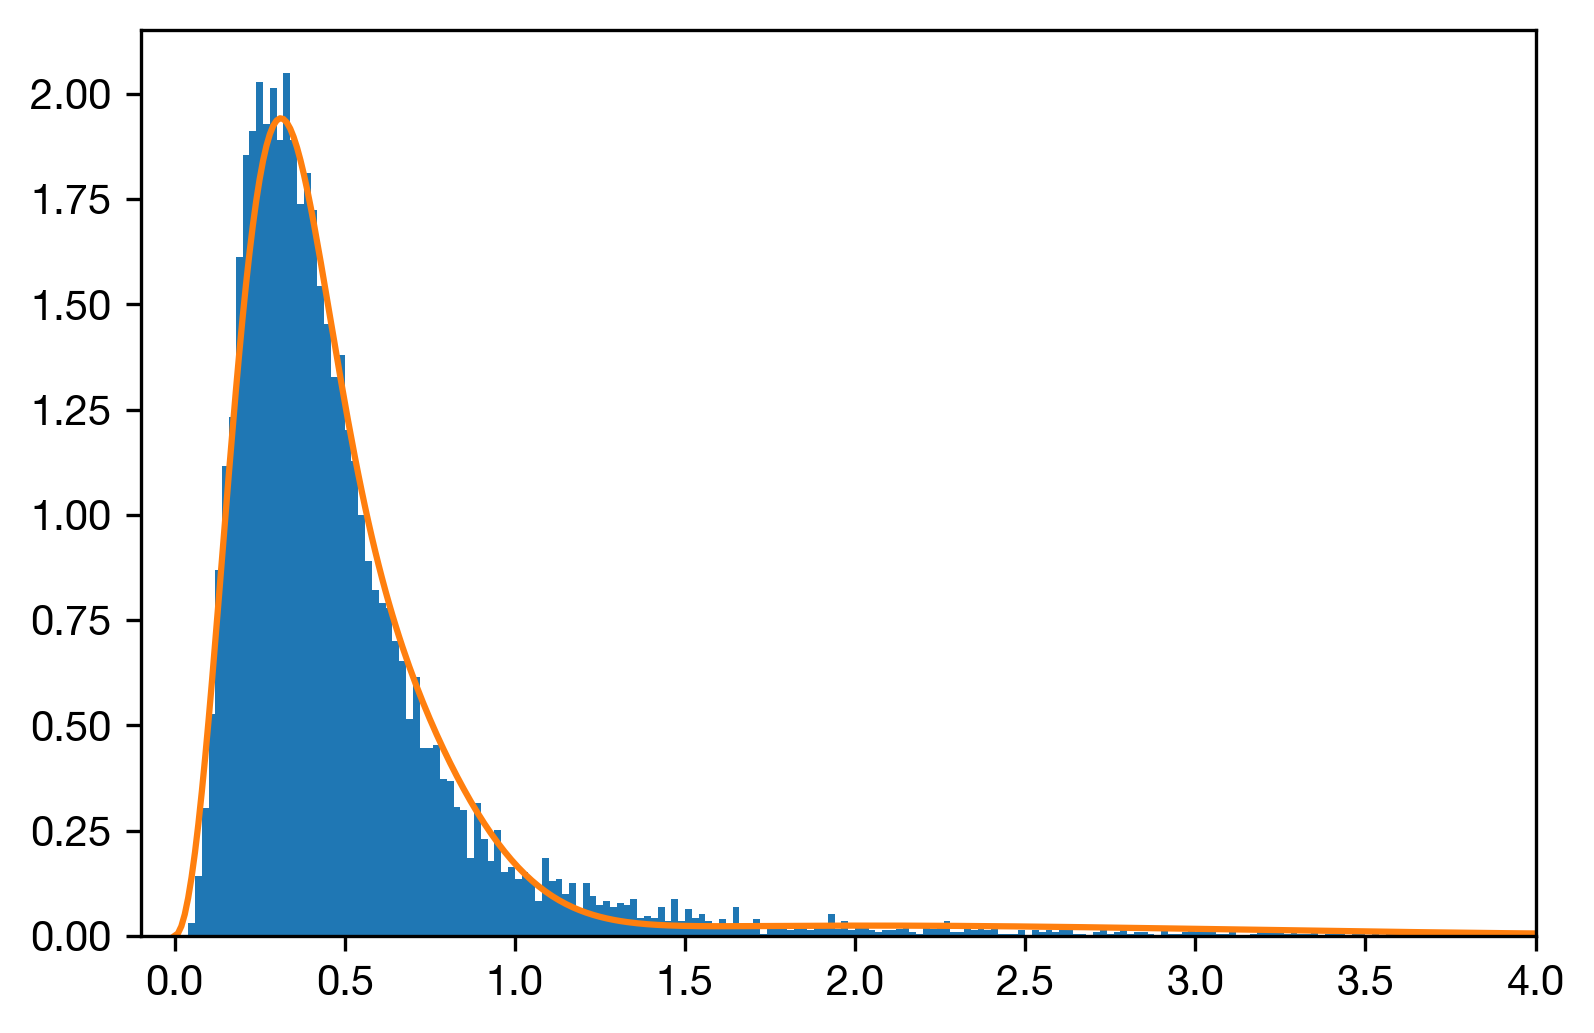

In [379]:
plt.hist(all_rmsf, bins = np.arange(0, 10, 0.02), density=True);
plt.xlim([-0.1, 4]);
x = np.arange(0, 5, 0.01)
fx = 0.500*stats.maxwell.pdf(x, scale = 0.2) +  0.44*stats.maxwell.pdf(x, scale = 0.36) +  0.06*stats.maxwell.pdf(x, scale = 1.45)

# plt.plot(x, (np.vstack([stats.maxwell.pdf(x, scale = a[k]) for k in range(3)]).T @ w))
plt.plot(x, fx)

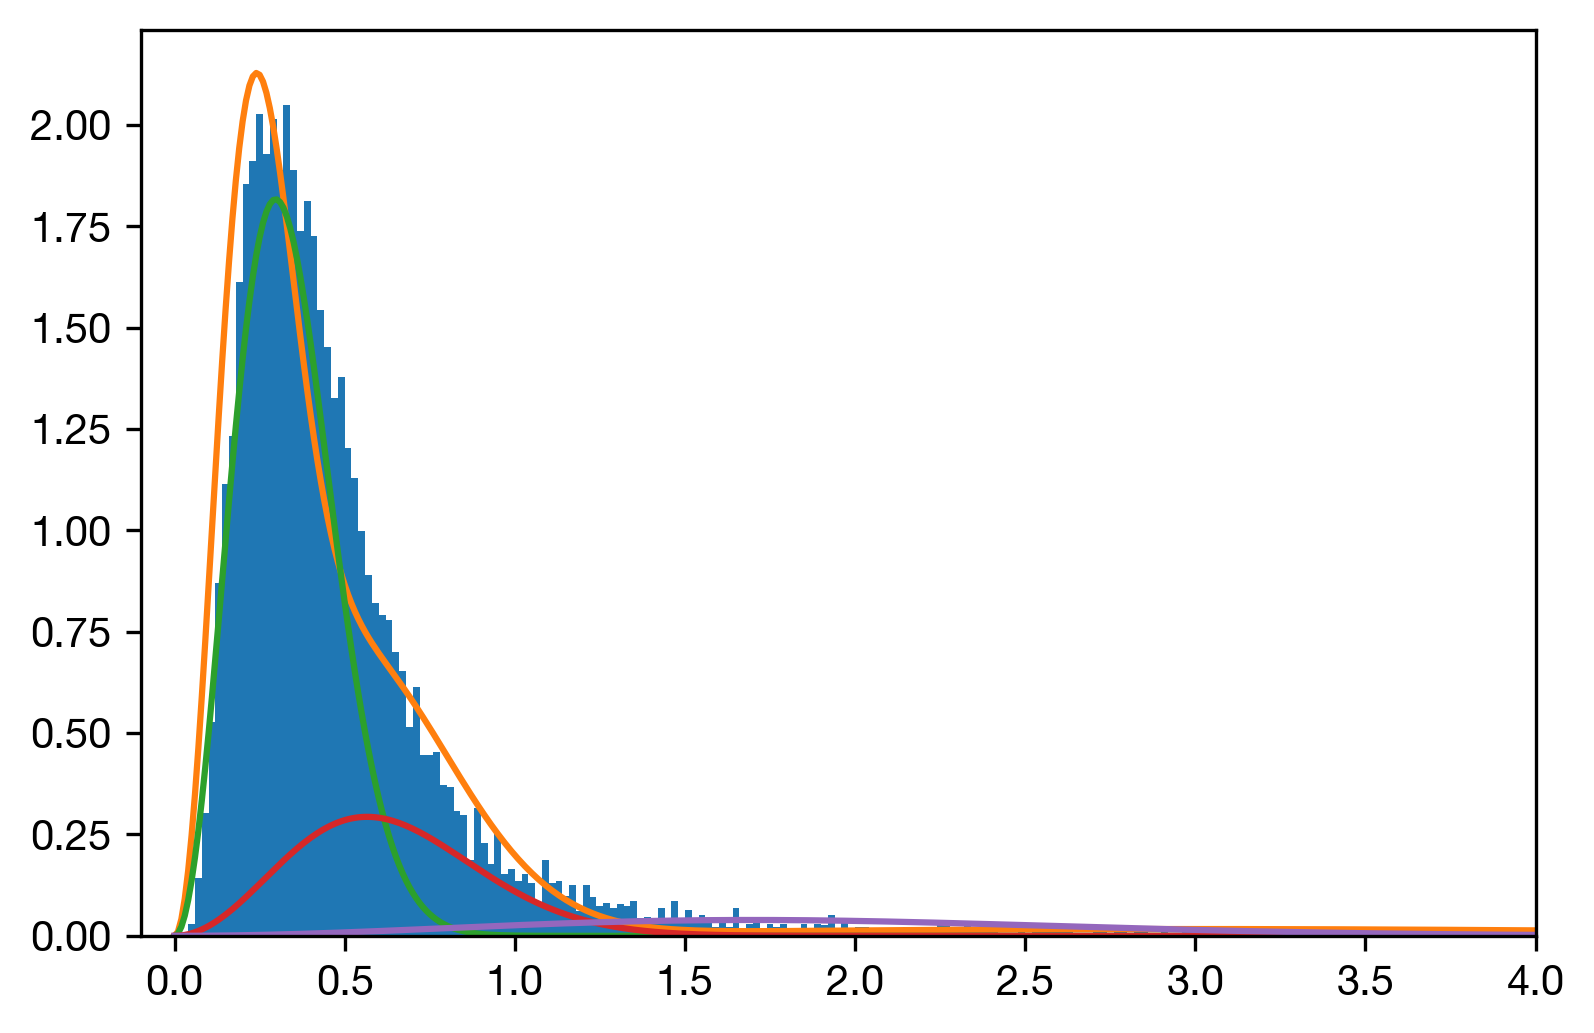

In [115]:
plt.hist(all_rmsf, bins = np.arange(0, 10, 0.02), density=True);
plt.xlim([-0.1, 4]);
x = np.arange(0, 5, 0.01)
fx1 = 0.65*stats.maxwell.pdf(x, scale = 0.21)
fx2 = 0.2*stats.maxwell.pdf(x, scale = 0.4) 
fx3 = 0.08*stats.maxwell.pdf(x, scale = 1.2)
plt.plot(x, fx1)
plt.plot(x, fx2)
plt.plot(x, fx3)

In [642]:
stds

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
244    1.281716
245    1.305701
246    1.289499
247    1.263704
248    1.239060
Length: 249, dtype: float64

In [100]:
def maxwell_mle(x):
    return np.sqrt((x**2).sum()/(3*len(x)))

def maxwell_em(x, K, n_iter = 1000):
    N = x.shape[0]
    z = np.random.choice(K, size = N)
    for i in range(n_iter):
        # E step
        a = np.array([maxwell_mle(x[z == k]) for k in range(K)])
        
        # M step
        probs = np.vstack([stats.maxwell.pdf(x, scale = a_) for a_ in a])
        z = probs.argmax(axis=0)
    w = np.array([z[z==k].shape[0] for k in range(K)])
    w = w/w.sum()
    return a,z,w  
        

In [101]:
a,z,w = maxwell_em(all_rmsf, 3, 10000)

In [103]:
w

array([0.0601192 , 0.43966485, 0.50021595])

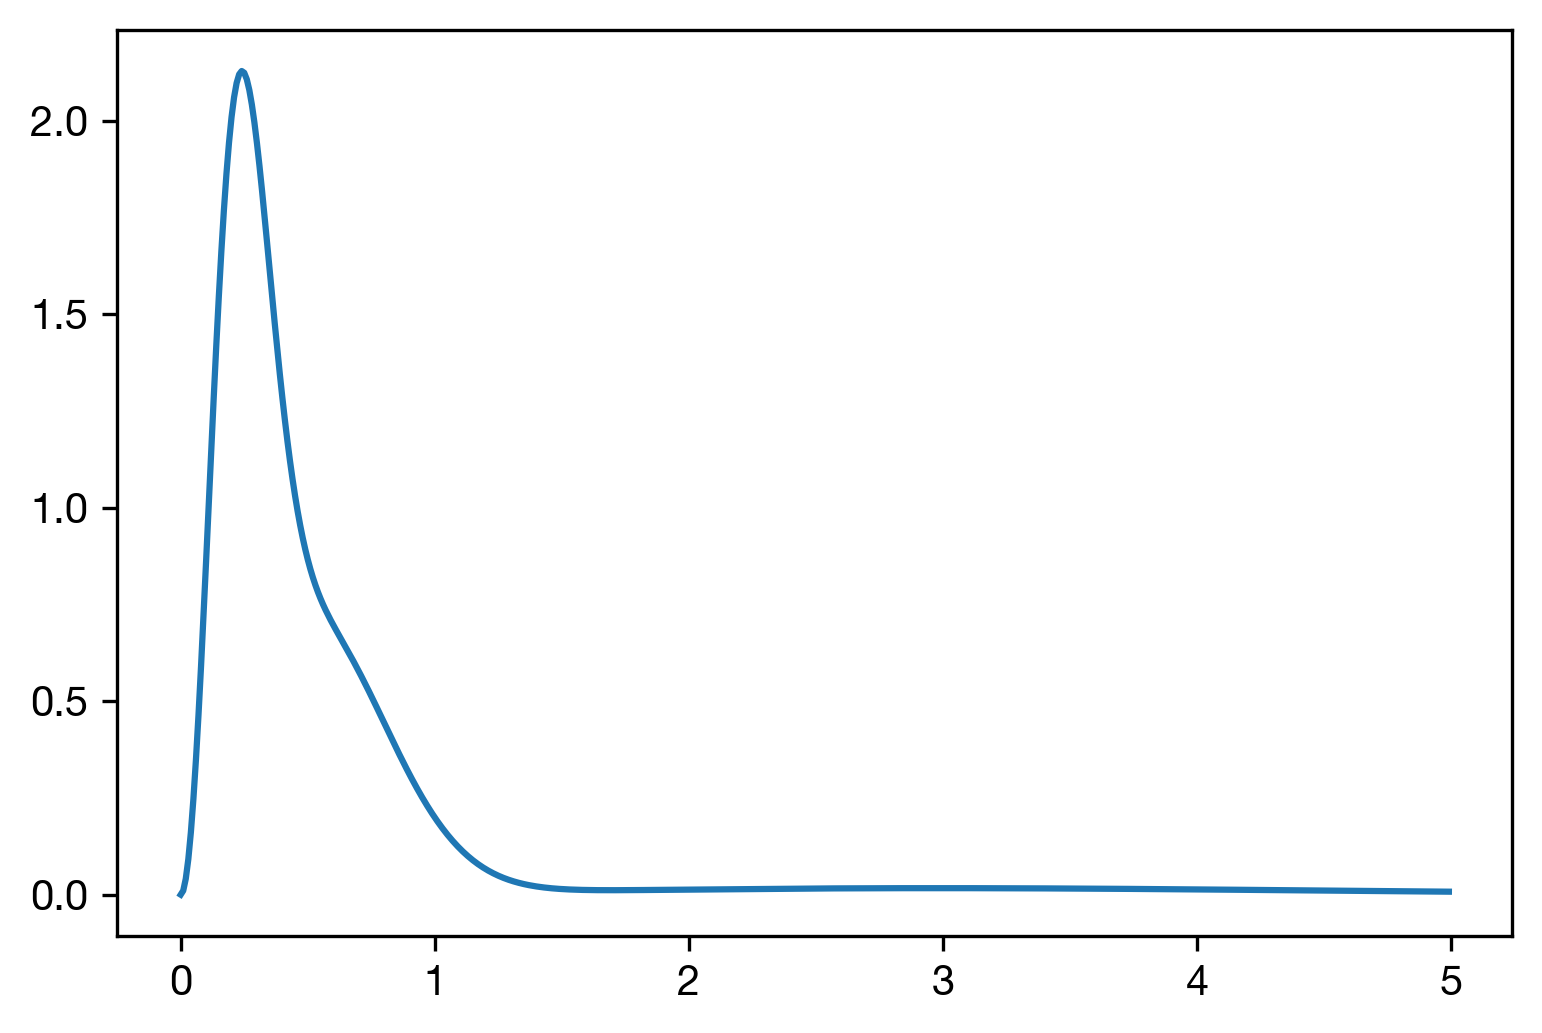

In [95]:
all_rmsf = np.array(all_rmsf)

In [96]:
all_rmsf = all_rmsf[~np.isnan(all_rmsf)]

In [104]:
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.